# 3. Spatial and spectral matching between multiband imaging data and IFS data cube -- Part I

<font size="4"> In this step, we will match (spatially, pixel-by-pixel) the reduced photometric data cube (produced from the previous step) and the IFS data cube from the CALIFA survey. This task can be performed using `piXedfit.piXedfit_spectrophotometric.specphoto_califagalexsdss2masswise` function. CALIFA data cube can be downloaded from this __[link](https://califa.caha.es/?q=content/califa-3rd-data-release)__. Only COMB data format (from CALIFA) can be analyzed with the current version of __piXedfit__.</font>

In [1]:
import numpy as np
from astropy.io import fits
import os, sys
import matplotlib.pyplot as plt

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME)

%matplotlib inline

In [2]:
from piXedfit.piXedfit_spectrophotometric import match_imgifs_spatial

## 3.1. Spatial matching between multiband imaging data and IFS data

In [3]:
photo_fluxmap = "fluxmap_ngc309.fits"              # photometric data cube
ifs_data = "NGC0309.COMB.rscube.fits.gz"
ifs_survey = "califa"
name_out_fits = "specphoto_fluxmap_ngc309.fits"
match_imgifs_spatial(photo_fluxmap, ifs_data, ifs_survey=ifs_survey, name_out_fits=name_out_fits)

Wave id: 1900 from 1901  ==> progress: 100%


## 3.2. Check the result: spectrophotometric data cube

In [4]:
cube = fits.open("specphoto_fluxmap_ngc309.fits")
cube.info()
print (cube[0].header)

Filename: specphoto_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PHOTO_FLUX    1 PrimaryHDU      34   (131, 131, 12)   float64   
  1  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  2  WAVE          1 ImageHDU         7   (1901,)   float64   
  3  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1901)   float64   
  4  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  5  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  6  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  7  STAMP_IMAGE    1 ImageHDU       107   (131, 131)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  131                                                  NAXIS2  =               

<font size="4"> **See coverages of Images and IFS**

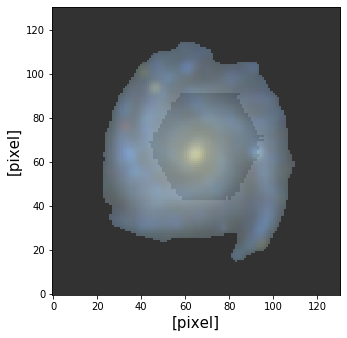

In [5]:
%matplotlib inline

from astropy.visualization import make_lupton_rgb

g = cube['PHOTO_FLUX'].data[3]*10
r = cube['PHOTO_FLUX'].data[4]*10
i = cube['PHOTO_FLUX'].data[5]*10

rgb_default = make_lupton_rgb(i, r, g)

### plot photo and spec+photo regio
fig1 = plt.figure(figsize=(5,5))
f1 = plt.subplot()
plt.xlabel('[pixel]', fontsize=15)
plt.ylabel('[pixel]', fontsize=15)

plt.imshow(rgb_default, origin='lower', alpha=1.0)
plt.imshow(cube['spec_region'].data*5, origin='lower', 
           cmap='Greys', alpha=0.2, vmin=0, vmax=10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)

<font size="4"> **Check SEDs of pixels**: including photometric and spectroscopic. </font>

In [6]:
# get unit of flux
unit = float(cube[0].header['unit'])

# get filters
nbands = int(cube[0].header['nfilters'])
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(cube[0].header[str_temp])

# get central wavelength of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

# get SEDs: transpose (band,y,x) => (y,x,band)
pix_photo_flux = np.transpose(cube['photo_flux'].data, axes=(1,2,0))*unit
pix_photo_flux_err = np.transpose(cube['photo_fluxerr'].data, axes=(1,2,0))*unit

# transpose (wave,y,x) => (y,x,wave)
pix_spec_flux = np.transpose(cube['spec_flux'].data, axes=(1,2,0))*unit
pix_spec_flux_err = np.transpose(cube['spec_fluxerr'].data, axes=(1,2,0))*unit

# wavelength
spec_wave = cube['wave'].data

<font size="4"> **Plot SEDs of some pixels in the central region**. In this data cube, the spectroscopic SEDs have not been corrected for the wavelength-dependent mismatch with the photometric SEDs. This will be done in next step using `piXedfit.piXedfit_spectrophotometric.match_specphoto`. </font>

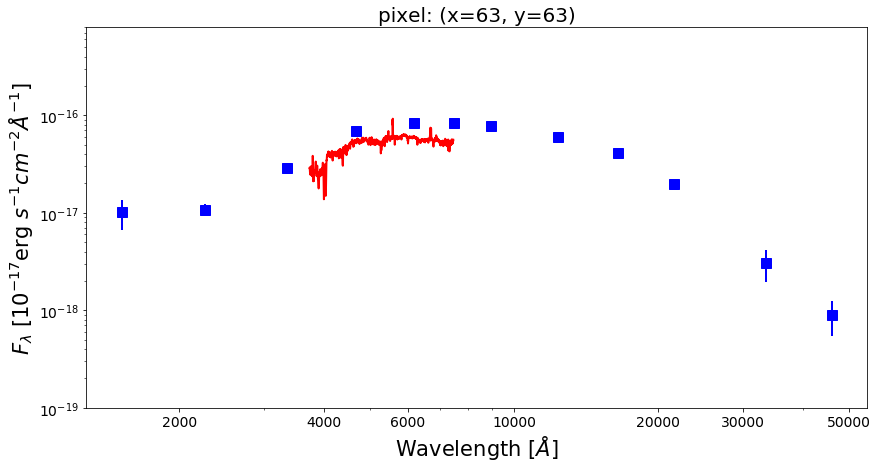

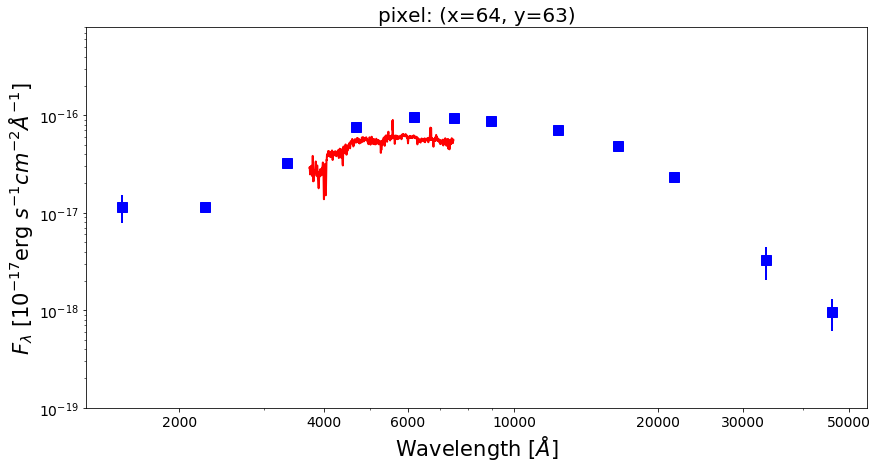

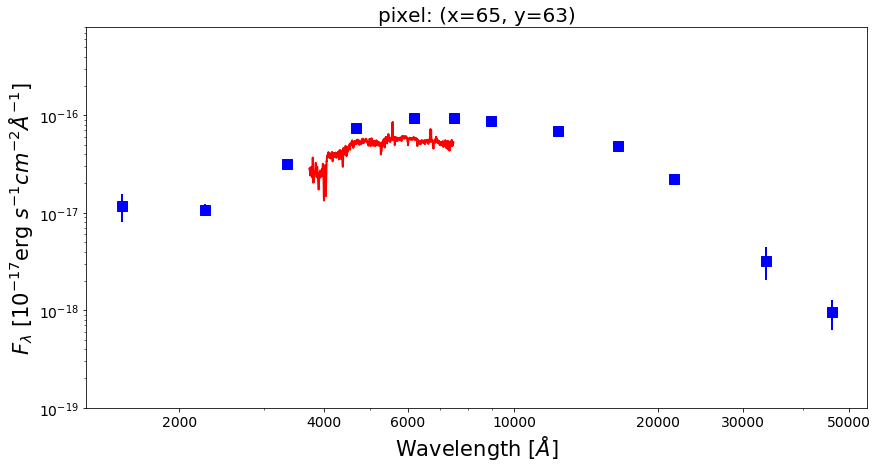

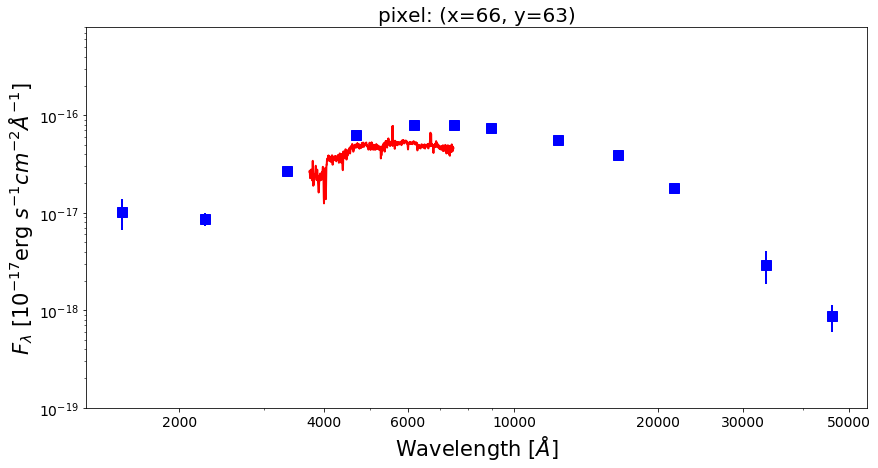

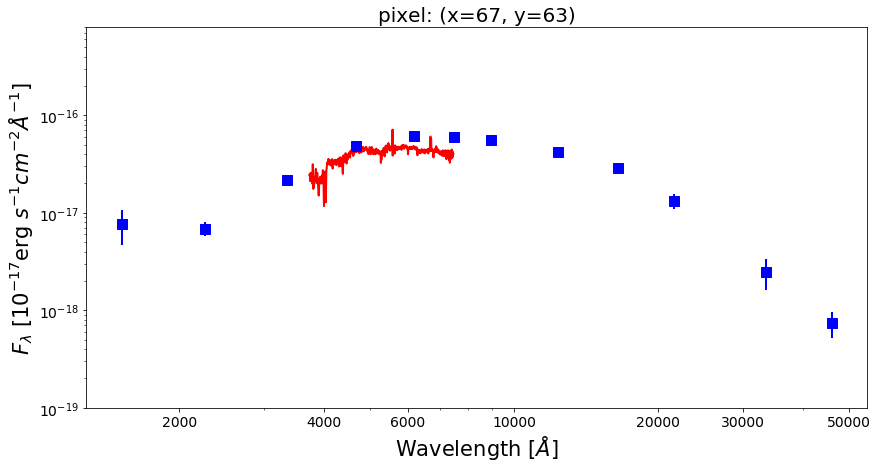

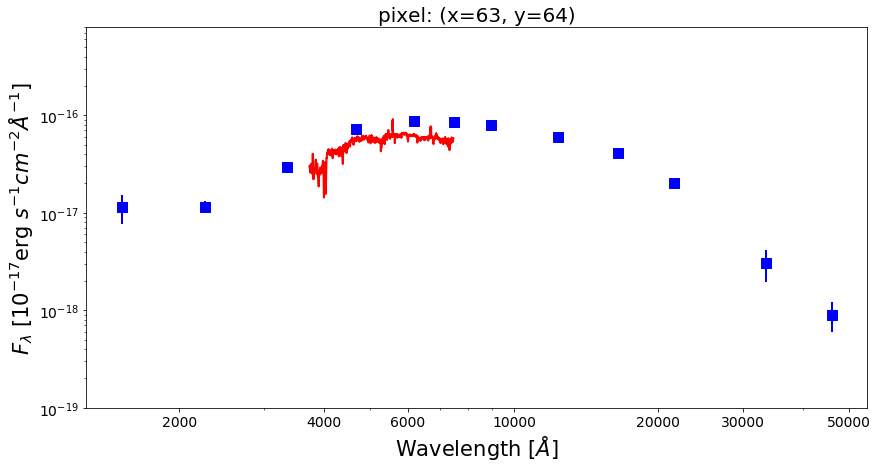

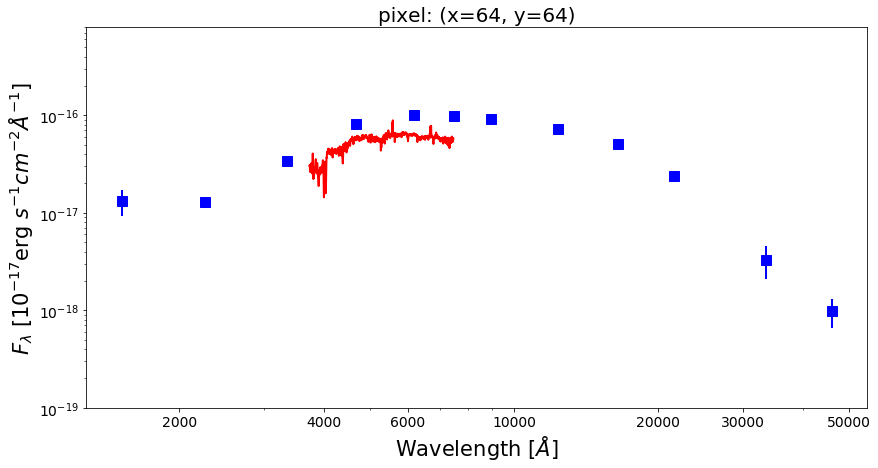

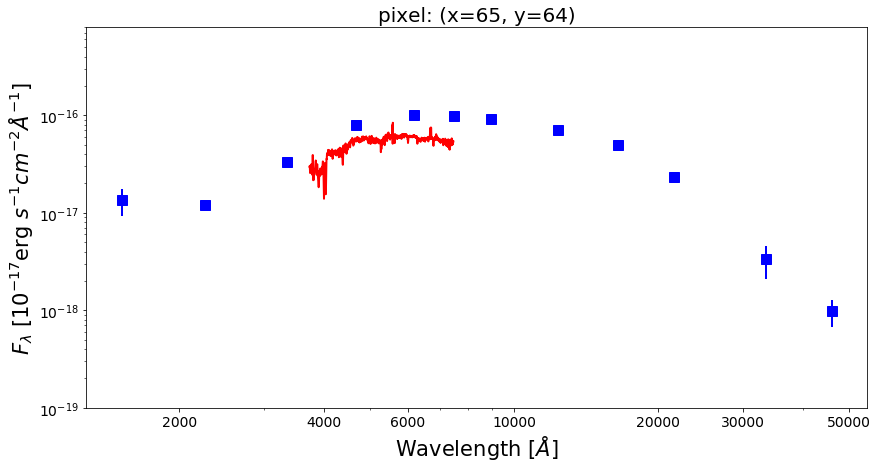

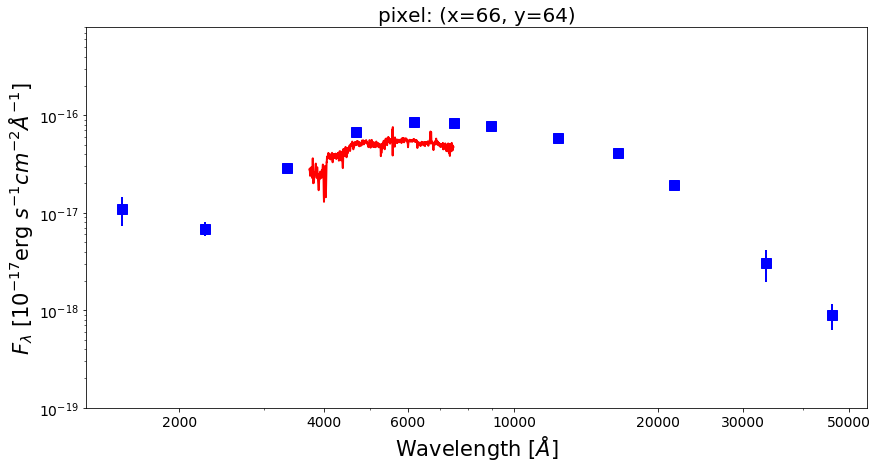

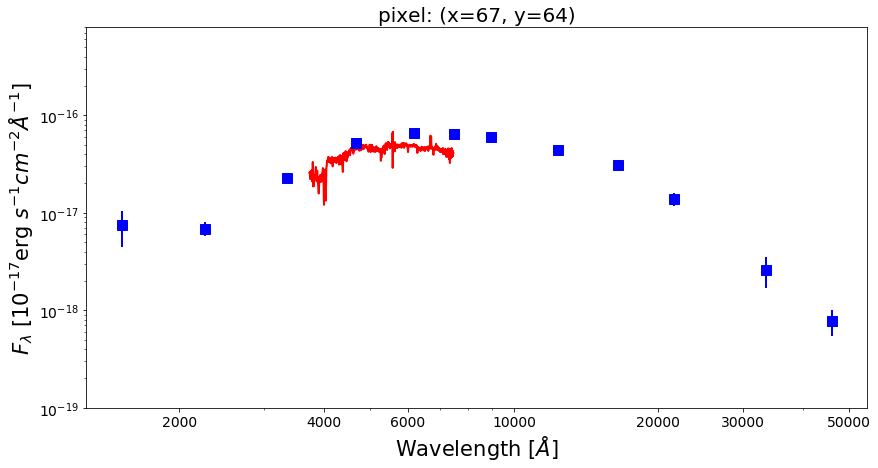

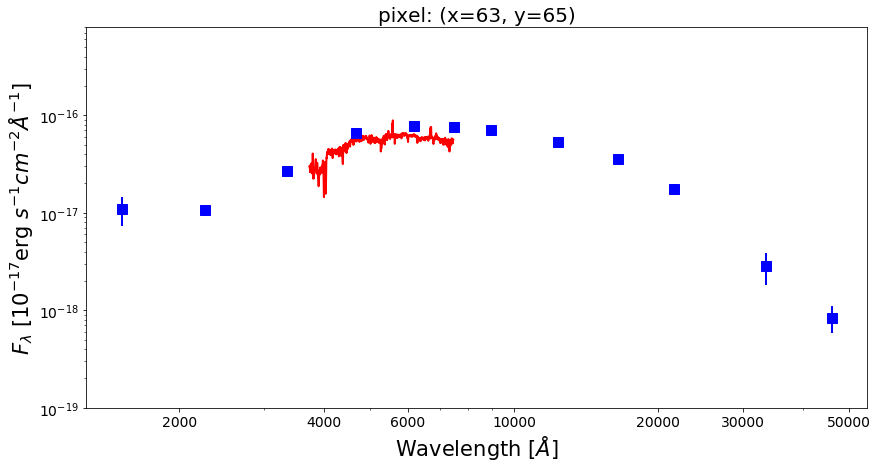

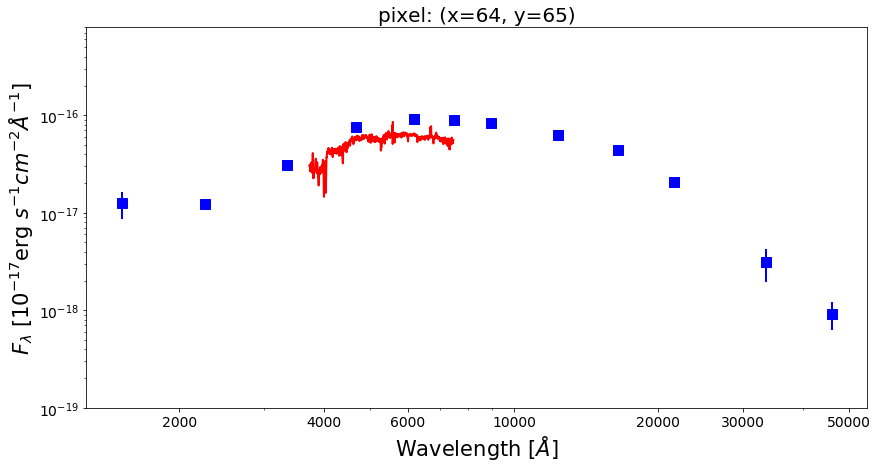

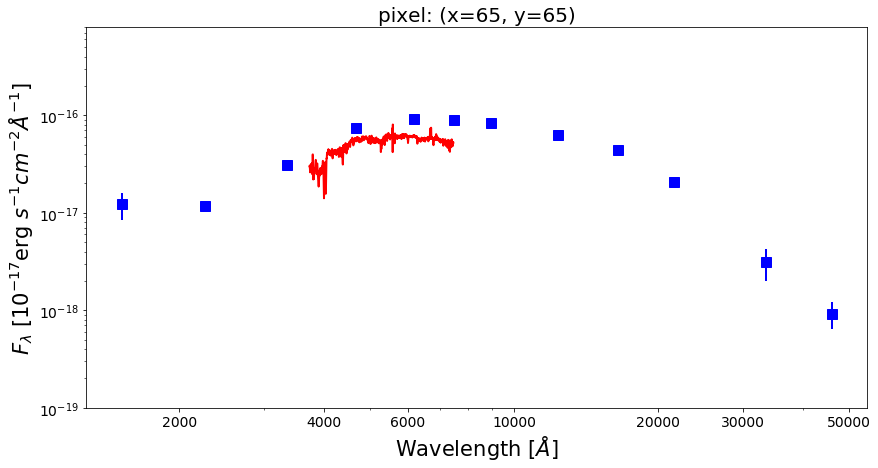

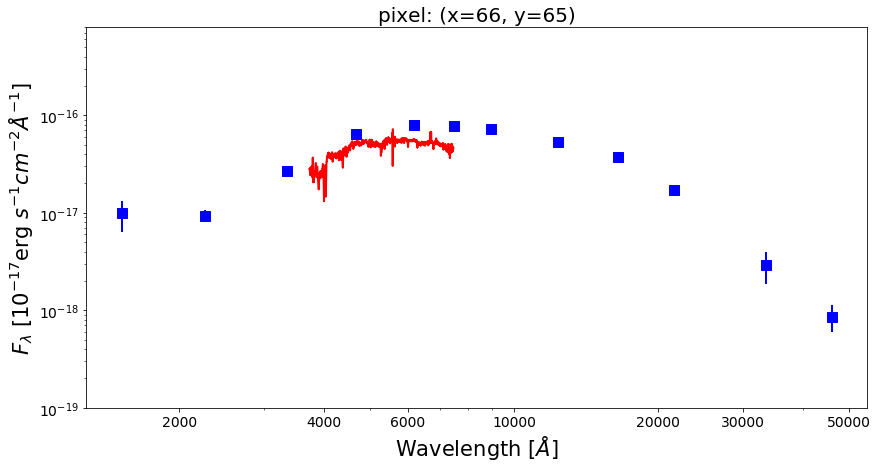

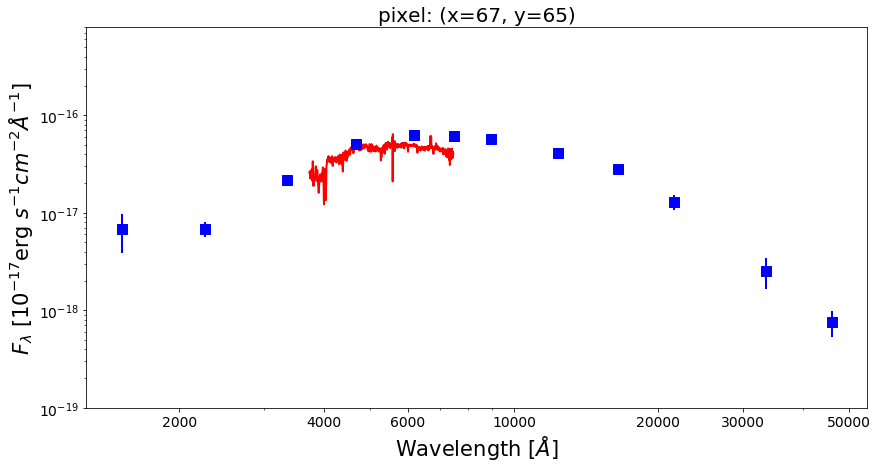

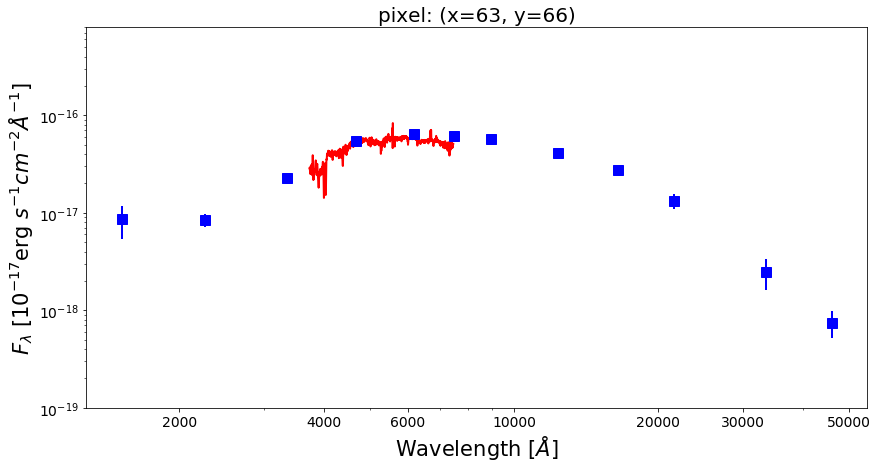

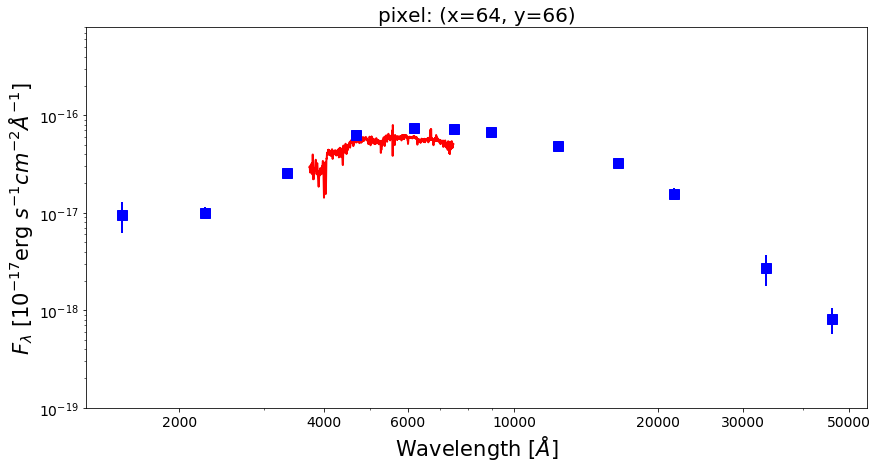

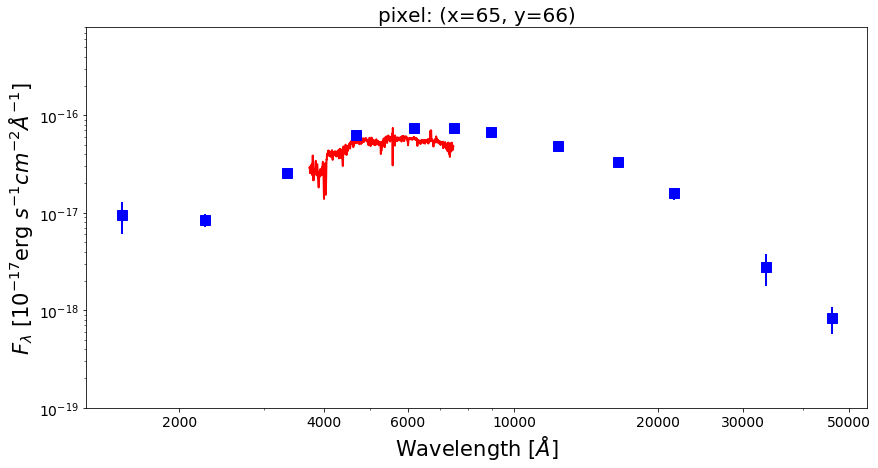

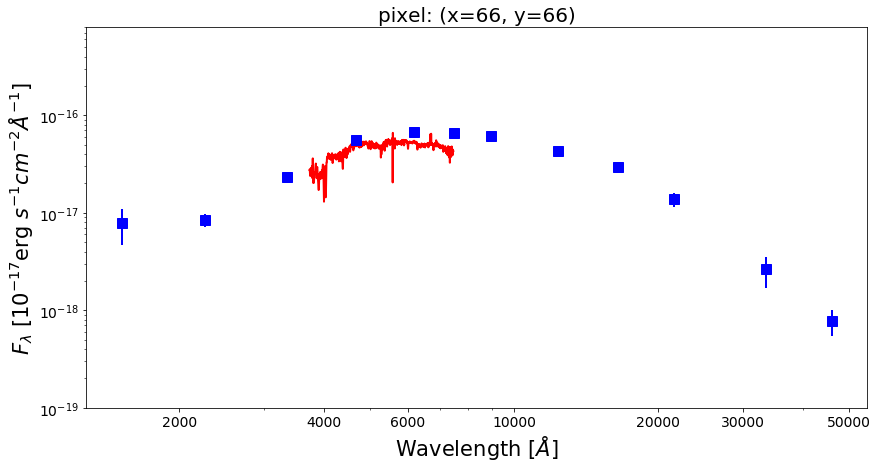

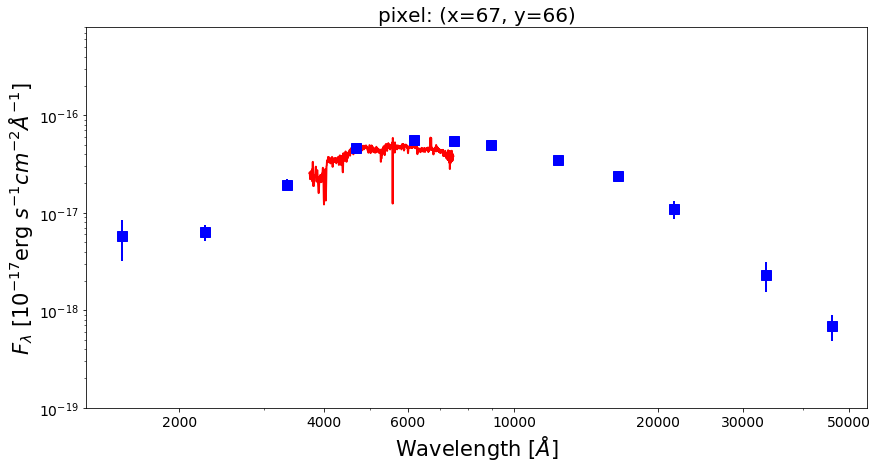

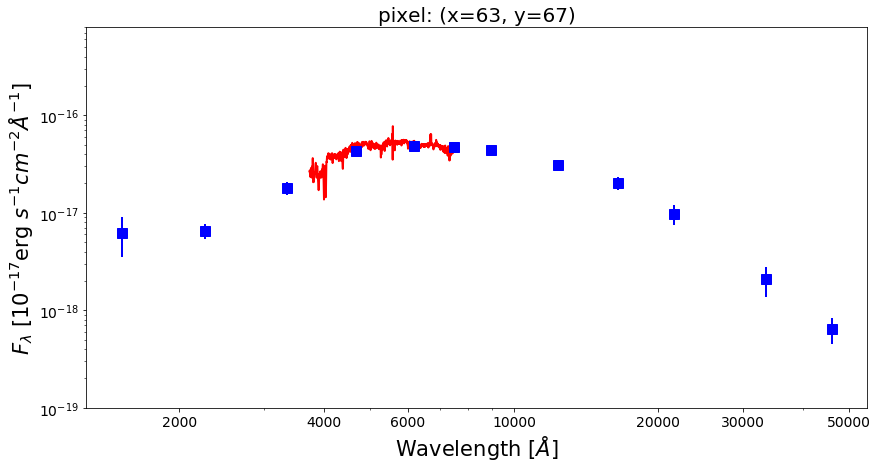

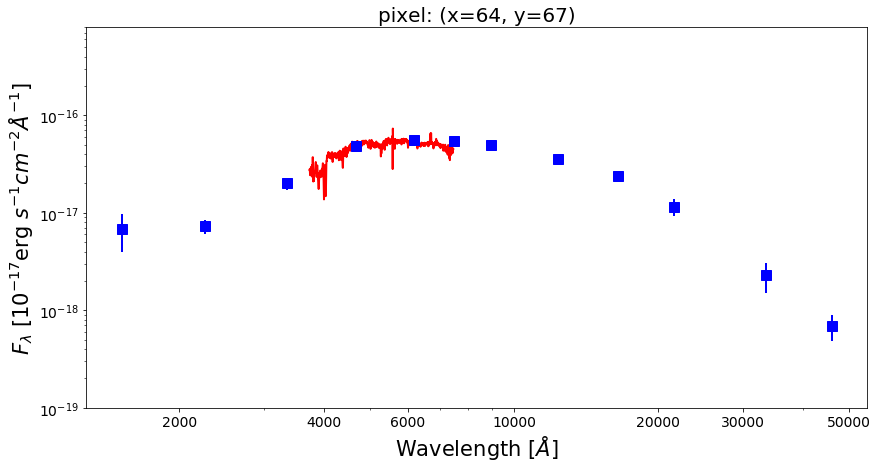

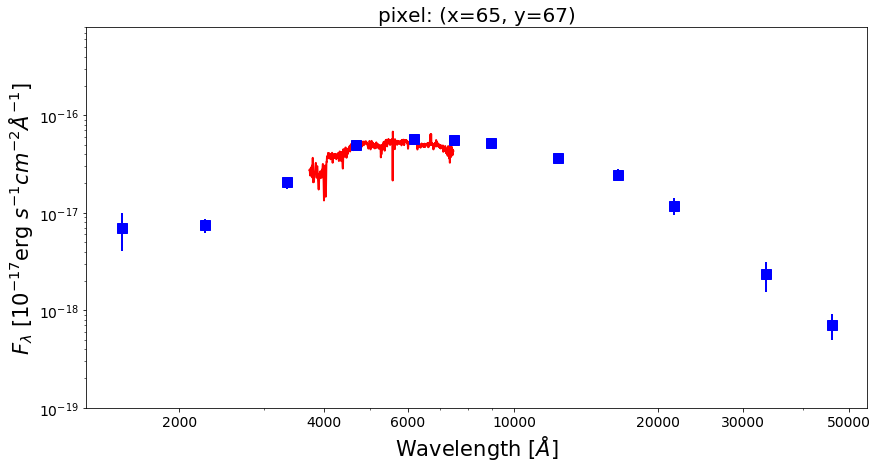

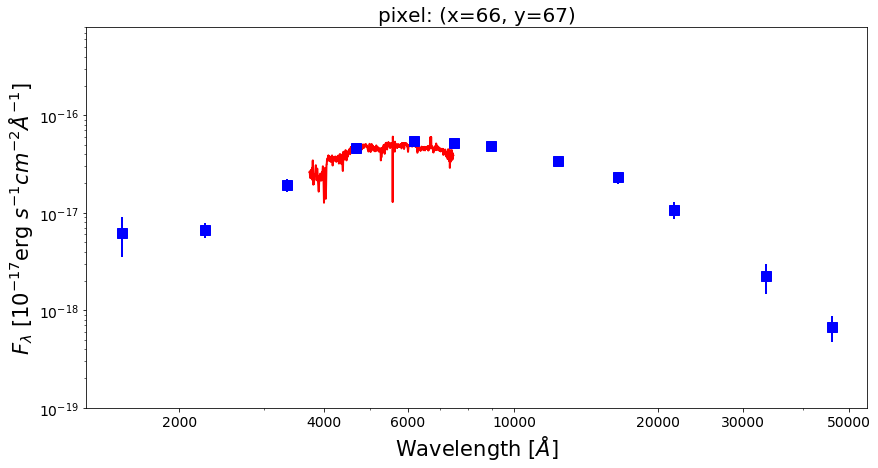

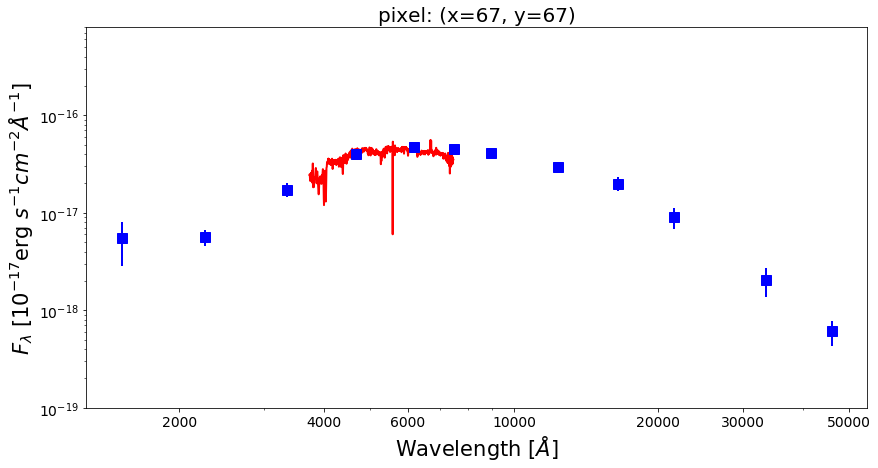

In [7]:
from matplotlib.ticker import ScalarFormatter

nwaves = len(spec_wave)

for yy in range(63,68):
    for xx in range(63,68):
        photo_SED = pix_photo_flux[yy][xx]
        photo_SED_err = pix_photo_flux_err[yy][xx]
        spec_SED = pix_spec_flux[yy][xx]
        spec_SED_err = pix_spec_flux_err[yy][xx]

        # plotting
        fig1 = plt.figure(figsize=(14,7))
        f1 = plt.subplot()   
        plt.title("pixel: (x=%d, y=%d)" % (xx,yy), fontsize=20)
        f1.set_yscale('log')
        f1.set_xscale('log')
        plt.setp(f1.get_yticklabels(), fontsize=14)
        plt.setp(f1.get_xticklabels(), fontsize=14)
        plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
        plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
        xticks = [2000,4000,6000,10000,20000,30000,50000]
        plt.xticks(xticks)
        #plt.xlim(3000,10000)
        plt.ylim(1.0e-19,8e-16)
        for axis in [f1.xaxis]:
            axis.set_major_formatter(ScalarFormatter())

        # Optional: cut the spectra around the edge to exclude 
        # those commonly uncertain fluxes
        plt.plot(spec_wave[20:nwaves-20], spec_SED[20:nwaves-20], lw=2.0, color='red')
        plt.errorbar(photo_wave, photo_SED, yerr=photo_SED_err, markersize=10,
                                color='blue', fmt='s', lw=2)